In [2]:
####################### IMPORTING ALL LIBRARIES #############################
# Core
import os
import json
import random
import itertools

# Math & Analysis
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Image Processing
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Vision
import torchvision.models as models
import torchvision.transforms as transforms

# Machine Learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

# Similarity Search
import faiss

##########################################################################
# Setting working directory
os.chdir("/home/ec2-user/SageMaker/spring-2025-final-project-project-group-4")
print("Current working directory:", os.getcwd())

Current working directory: /home/ec2-user/SageMaker/spring-2025-final-project-project-group-4


## 1. Load Embeddings and Meta
### Load the clothing embeddings and metadata from filesdata


In [3]:
with open("Parsa/checkpoint/clothing_embeddings.json", "r") as f:
    embedding_dict = json.load(f)

with open("metadata.json", "r") as f:
    metadata = json.load(f)

metadata_lookup = {
    f"Parsa/clothes/{category}/{item['filename']}": item
    for category, items in metadata.items() for item in items
}

## 2. Define Embedding Network and Load Weights
### Define the neural network for embedding and load pretrained weights

In [5]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        return self.fc(x)

embedding_net = EmbeddingNet()
embedding_net.load_state_dict(torch.load("Parsa/checkpoint/siamese_model.pth"))
embedding_net.eval()

EmbeddingNet(
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

## 3. Find Best Matches (Hard Style Filter)
### Finds and returns the most compatible matches with strict style filtering

In [6]:
def find_best_matches(query_path, mode="top", top_k=5):
    query_embedding = embedding_dict[query_path]
    query_tensor = torch.tensor(query_embedding).float().unsqueeze(0)
    query_style = metadata_lookup.get(query_path, {}).get("style", [])

    candidates = [p for p in embedding_dict if (
        ("pants" in p or "shorts" in p) if mode == "top" else ("shirts" in p or "t-shirts" in p)
    )]

    scores = []
    for candidate_path in candidates:
        candidate_embedding = embedding_dict[candidate_path]
        candidate_tensor = torch.tensor(candidate_embedding).float().unsqueeze(0)

        with torch.no_grad():
            out1 = embedding_net(query_tensor)
            out2 = embedding_net(candidate_tensor)
            dist = torch.nn.functional.pairwise_distance(out1, out2).item()

        candidate_style = metadata_lookup.get(candidate_path, {}).get("style", [])
        if not set(query_style).intersection(set(candidate_style)):
            continue  # skip mismatched styles

        scores.append((candidate_path, dist))

    scores.sort(key=lambda x: x[1])
    return scores[:top_k]

## 4. Display Matches
### Visualizes the query and top outfit matches

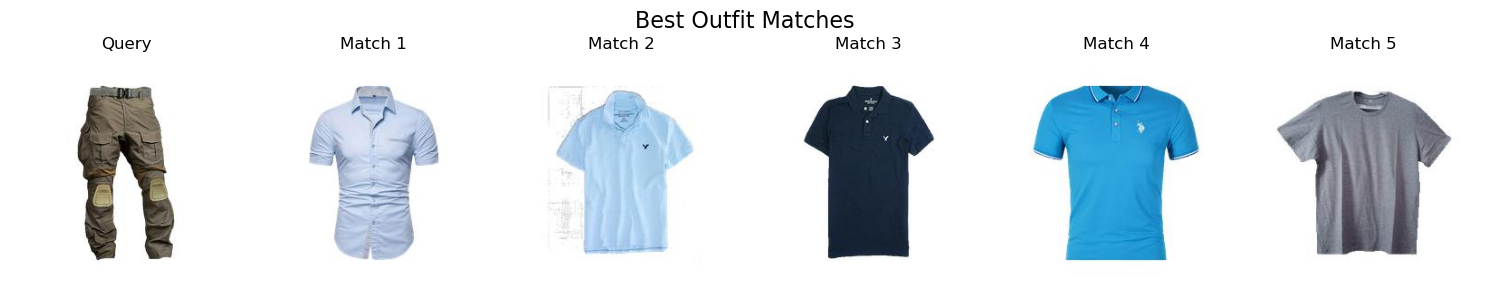

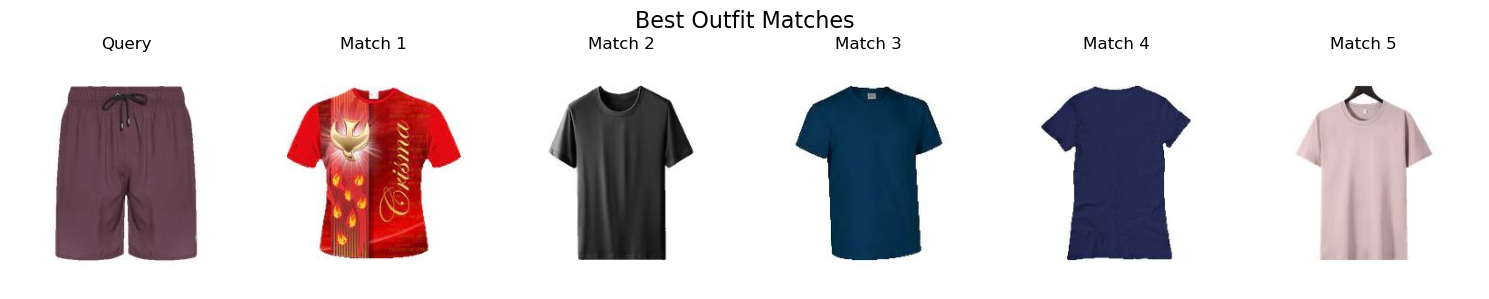

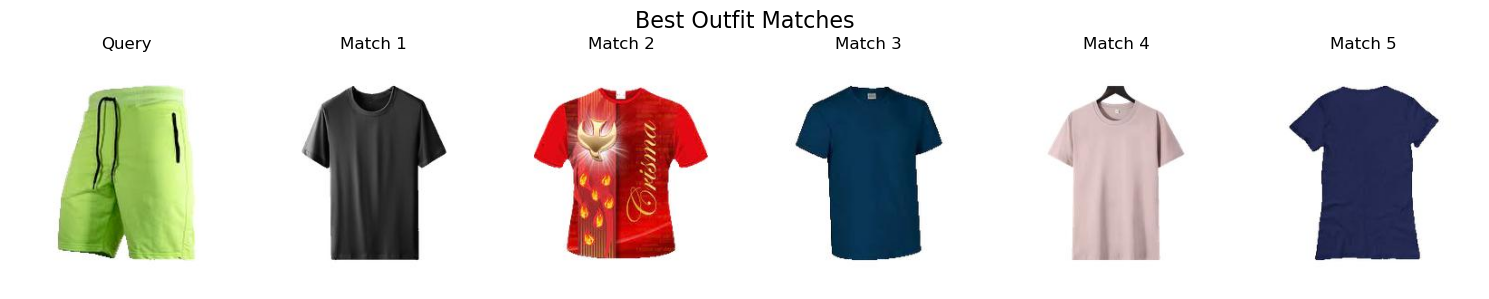

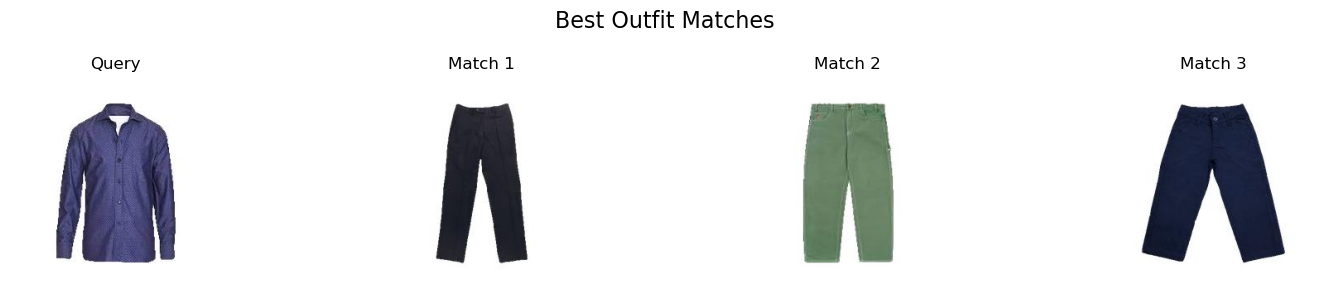

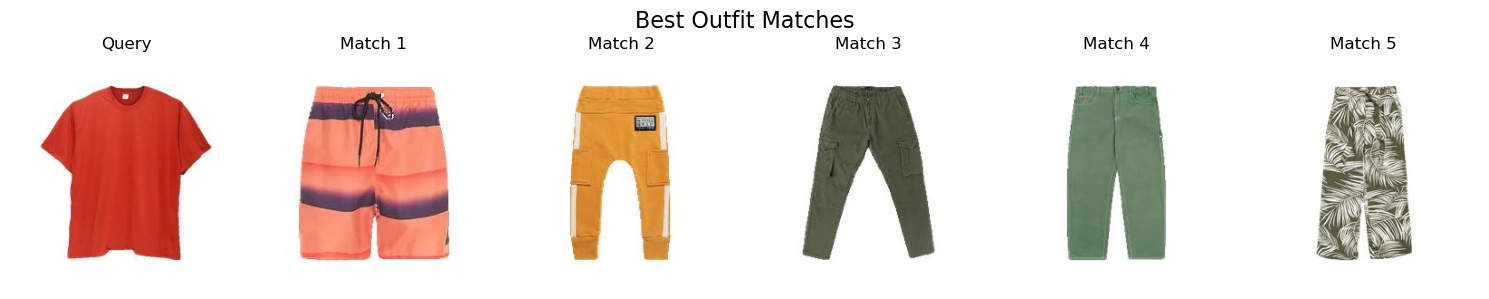

In [7]:
def display_match_results(query_path, matches):
    paths = [query_path] + [m[0] for m in matches]
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(paths):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, len(paths), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Query" if i == 0 else f"Match {i}")
    plt.suptitle("Best Outfit Matches", fontsize=16)
    plt.tight_layout()
    plt.show()

# === Example Queries ===
for path in [
    "Parsa/clothes/pants/01_pants.jpg",
    "Parsa/clothes/shorts/13_shorts.jpg",
    "Parsa/clothes/shorts/40_shorts.jpg",
    "Parsa/clothes/shirts/06_shirts.jpg",
    "Parsa/clothes/t-shirts/28_t-shirts.jpg"
]:
    matches = find_best_matches(path, mode="bottom" if "pants" in path or "shorts" in path else "top")
    display_match_results(path, matches)


## 5. Distance Histogram (Contrastive Learning Evaluation)
### Visualizes the distribution of distances between positive and negative pairs

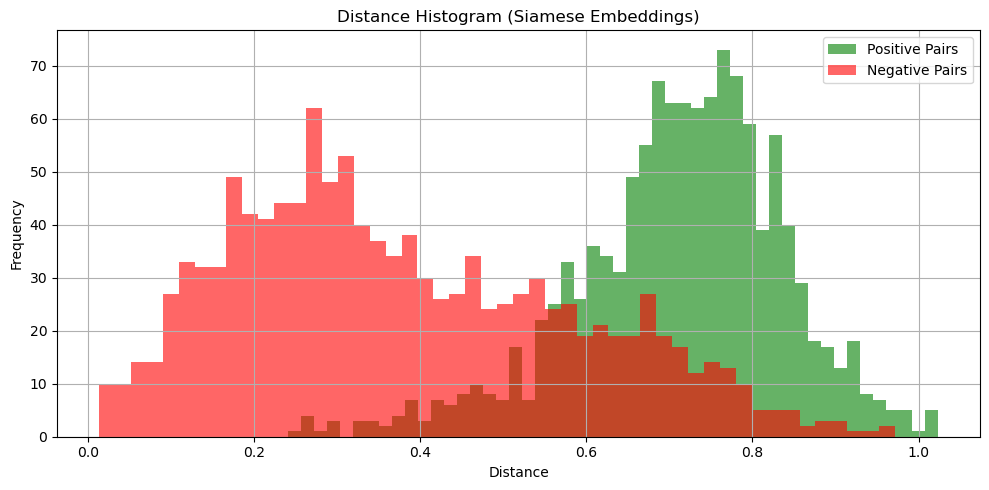

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_net = EmbeddingNet()

    def forward(self, x1, x2):
        out1 = self.embedding_net(x1)
        out2 = self.embedding_net(x2)
        return out1, out2

with open("Parsa/checkpoint/training_pairs.json", "r") as f:
    training_pairs = json.load(f)

model = SiameseNetwork()
model.embedding_net.load_state_dict(torch.load("Parsa/checkpoint/siamese_model.pth"))
model.eval()

positive_distances = []
negative_distances = []

with torch.no_grad():
    for pair in training_pairs:
        t1 = torch.tensor(pair["top_embedding"]).float().unsqueeze(0)
        t2 = torch.tensor(pair["bottom_embedding"]).float().unsqueeze(0)
        out1, out2 = model(t1, t2)
        dist = torch.nn.functional.pairwise_distance(out1, out2).item()
        (positive_distances if pair["label"] == 1 else negative_distances).append(dist)

plt.figure(figsize=(10, 5))
plt.hist(positive_distances, bins=50, alpha=0.6, label="Positive Pairs", color="green")
plt.hist(negative_distances, bins=50, alpha=0.6, label="Negative Pairs", color="red")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distance Histogram (Siamese Embeddings)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. t-SNE Visualization of Embedding Space
### Projects all clothing embeddings into 2D space to visualize clustering by category

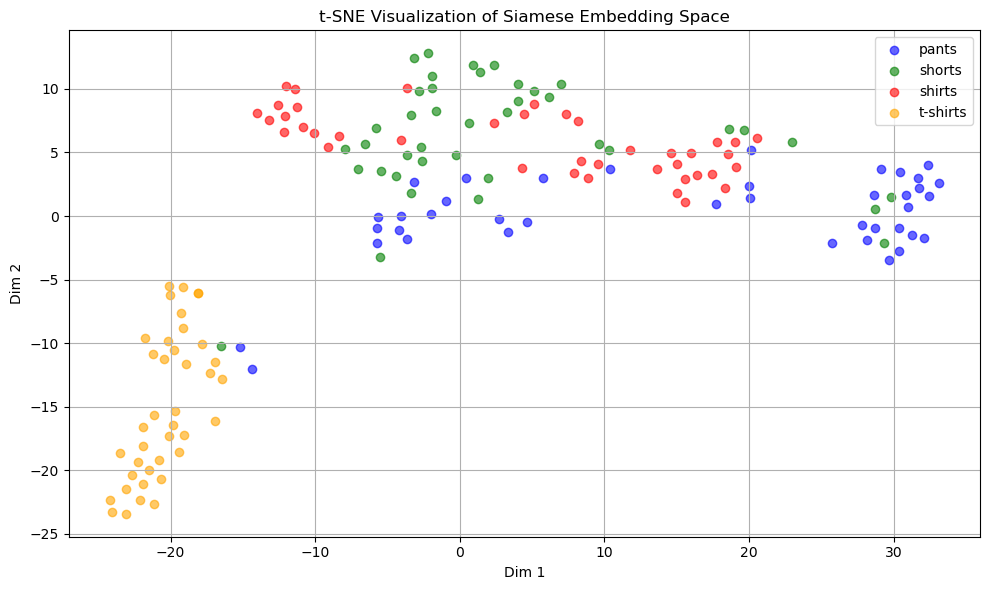

In [12]:
embedding_net = EmbeddingNet()
embedding_net.load_state_dict(torch.load("Parsa/checkpoint/siamese_model.pth"), strict=False)
embedding_net.eval()

projected_embeddings = []
labels = []

for path, emb in embedding_dict.items():
    tensor = torch.tensor(emb).float().unsqueeze(0)
    with torch.no_grad():
        proj = embedding_net(tensor).squeeze().numpy()
    projected_embeddings.append(proj)
    
    if "pants" in path:
        labels.append("pants")
    elif "shorts" in path:
        labels.append("shorts")
    elif "t-shirts" in path:
        labels.append("t-shirts")
    elif "shirts" in path:
        labels.append("shirts")
    else:
        labels.append("unknown")

projected_embeddings = np.array(projected_embeddings)
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
reduced = tsne.fit_transform(projected_embeddings)

plt.figure(figsize=(10, 6))
colors = {
    "pants": "blue", "shorts": "green", "shirts": "red",
    "t-shirts": "orange", "unknown": "gray"
}
for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label, c=colors[label], alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of Siamese Embedding Space")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()